# Construcción de Carro Autónomo mediante algoritmo DQN con Pytorch y Kivy

En este trabajo se explora el uso del algoritmo DQN para resolver la problemática de un carro autónomo que debe viajar desde el centro de una ciudad hacia un aeropuerto y viceversa; por lo que en cada momento se necesita obtener una ruta óptima para su recorrido, esta experiencia es simulada usando la plataforma Kivy y la libreria pytorch de python; de tal forma que Kivy actúe como visualizador y pytorch nos proporcione las herramientas para la implementación de nuestra DQN, dando como resultado que varios agentes logren viajar desde el origen hacia la meta evitando choques entre sí y sorteando obstáculos a medida que estos son instanciados en el mapa de forma interactiva.

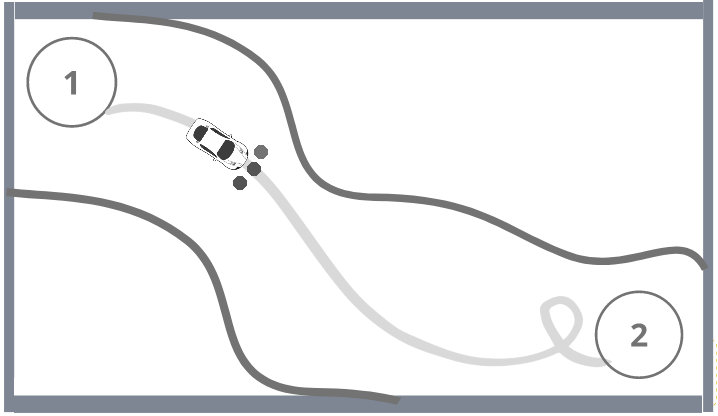

## Algoritmo Q-Learning 

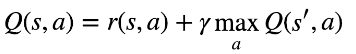

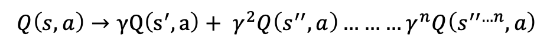

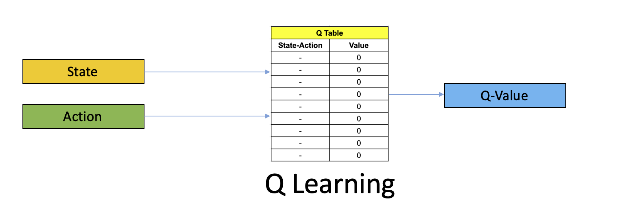

## Algoritmo Q-Learning Profundo

Para una cantidad de estados grande, tendriamos que calcular el valor de Q para los estados de cada estado, presentando un problema de insuficiencia de memoria requerida para tal objetivo, por lo que el aprendizaje Q-Learning Profundo establece una solución eficaz, hacer predicciones de Q mediante una red neuronal.

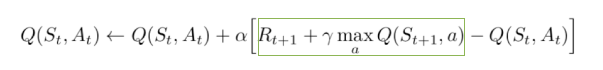

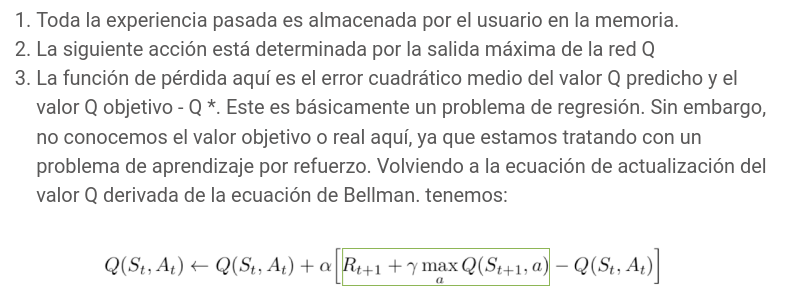

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time

### 1. RED NEURONAL PREDICTORA DE Q-VALUES

Para poder Predecir los Q-values de las acciones disponibles.

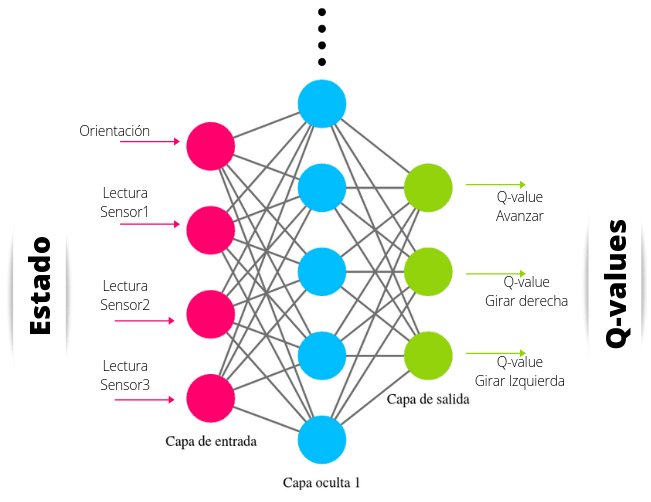

In [2]:
class Network(nn.Module):

    def __init__(self, input_size, nb_action):
        super(Network, self).__init__()
        self.input_size = input_size
        self.nb_action = nb_action
        # Combinacion Lineal de toda la data
        self.fc1 = nn.Linear(input_size, 30)

        # Combinacion Lineal de toda la data
        self.fc2 = nn.Linear(30, nb_action)

    def forward(self, state):
        x = F.tanh(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

In [4]:
model = Network(4, 3)

In [5]:
class Dqn(object):

    def __init__(self, input_size, nb_action, gamma):
        self.start = time.time()
        self.gamma = gamma  # Para las penalizaciones
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity=100000)
        # variante del descenso del Gradiente
        self.optimizer = optim.Adam(params=self.model.parameters())
        self.last_state = torch.Tensor(input_size).unsqueeze(
            0)  # Tensor Vacio de dimension [0,3]
        self.last_action = 0
        self.last_reward = 0

    def select_action(self, state):  # Selecciona una accion
        # Probabilidades del estado actual:
        probs = F.softmax(self.model(Variable(state))*100)
        action = probs.multinomial(len(probs))
        #print(f"Action : {action}")
        #print(f"Action : {type(action)}")
        return action.data[0, 0]

    def learn(self, batch_states, batch_actions, batch_rewards, batch_next_states):
        #print("Salida model :", end=" ")
        # print(self.model(batch_states).shape)#Salidas
        # Le pasamos la orientacion, y las 3 acciones
        # print((batch_states).shape)

        # Conseguimos el output del Modelo.
        # Gather hace la eleccion, con unsqueeze agregamos una dimension para seguir
        # trabajando con la eleccion, y despues con squeeze le bajamos a la dimension inicial
        # para obtener las salidas del Modelo
        batch_outputs = self.model(batch_states).gather(
            1, batch_actions.unsqueeze(1)).squeeze(1)

        # print(batch_outputs.shape)
        print(batch_next_states)
        # Recibe una tupla de dimension 3 y devuelve el maximo valor
        # de cada una de las tuplas evaluadas, y se almacena en batch_next_outputs
        print(batch_next_states)
        batch_next_outputs = self.model(batch_next_states).detach().max(1)[0]

        # Q(s,a) = R(s,a) + gamma*max(Q(s',a))
        # Q(varios) para el lote examinado
        batch_targets = batch_rewards + self.gamma * batch_next_outputs

        # Calculamos la perdida y tratamos de minimizar la perdida con el Optimizador
        # Adam
        td_loss = F.smooth_l1_loss(batch_outputs, batch_targets)
        self.optimizer.zero_grad()  # -> Poner los gradientes a Cero
        td_loss.backward()  # -> Backpropagation, obtenemos las gradientes
        self.optimizer.step()  # -> actualizando los pesos con Adam

    def update(self, new_state, new_reward):
        # Convierte el estado a un tensor float, y le aumenta 1 dimension
        new_state = torch.Tensor(new_state).float().unsqueeze(0)

        # Agregando a la memoria un evento, el evento es:
        # El estado actual, la accion, la recompensa, y el estado siguiente
        # last_state es el estado actual
        # last_reward -> la recompensa inmediata
        # new_state -> el estado siguiente
        self.memory.push((self.last_state, torch.LongTensor(
            [int(self.last_action)]), torch.Tensor([self.last_reward]), new_state))

        # Le pasamos un estado, y con select_action elije la accion
        # a tomar, de las probabilidades con la multinomial
        # tomando una accion [0,1,2]
        new_action = self.select_action(new_state)

        # Si la memoria de eventos se llena significa que
        # Empezamos a aprender tomando 100 muestras
        # Y lo mandamos a aprender, siempre y cuando tengamos
        # + de 100 muestras

        if len(self.memory.memory) > 100:
            # print(time.time() - self.start) #Tiempo que demora en entrar
            batch_states, batch_actions, batch_rewards, batch_next_states = self.memory.sample(
                100)
            self.learn(batch_states, batch_actions,
                       batch_rewards, batch_next_states)
        self.last_state = new_state
        self.last_action = new_action
        self.last_reward = new_reward
        return new_action
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    }, 'last_brain.pth')

    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> cargar checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("hecho !")
        else:
            print("no checkpoint encontrado...")

In [6]:
brain = Dqn(4, 3, 0.8)

In [8]:
brain.load()

=> cargar checkpoint... 
hecho !


### Enviando datos a nuestro dqn

In [9]:
#Deteccion de obstaculo por parte del sensor 2
state = [-0.5, 1.0, 1.0, 1.0]
#Acercandose a la meta 
reward = -1 
action = brain.update(state, reward)
print(action)

tensor(2)


/home/adr/my_project_dir/my_project_env/lib/python3.5/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/adr/my_project_dir/my_project_env/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Resultados Obtenidos

![SegmentLocal](demo2.gif "segment")